In [1]:
# data generation
import numpy as np
import pandas as pd

X = []; Y = []
for k in range(1000):
    x1 = np.random.rand()*100.0
    x2 = np.random.rand()*100.0
    if ((x1 > 50) or (x2>50)) and not ((x1>50) and (x2>50)):
        y = 1
    else:
        y =  0
        
    X.append([x1,x2])
    Y.append(y)
    
df = pd.DataFrame({'x1':[x[0] for x in X], 'x2':[x[1] for x in X], 'y':Y})
df.head(10)

,x1,x2,y
0,1.744960,0.340218,0
1,23.063714,56.858870,1
2,91.079115,17.488829,1
3,10.871268,29.413883,0
4,90.352583,20.099619,1
5,14.978738,2.128023,0
6,97.818977,65.053446,0
7,87.952580,47.034181,1
8,69.381945,39.202029,1
9,21.667610,57.273886,1


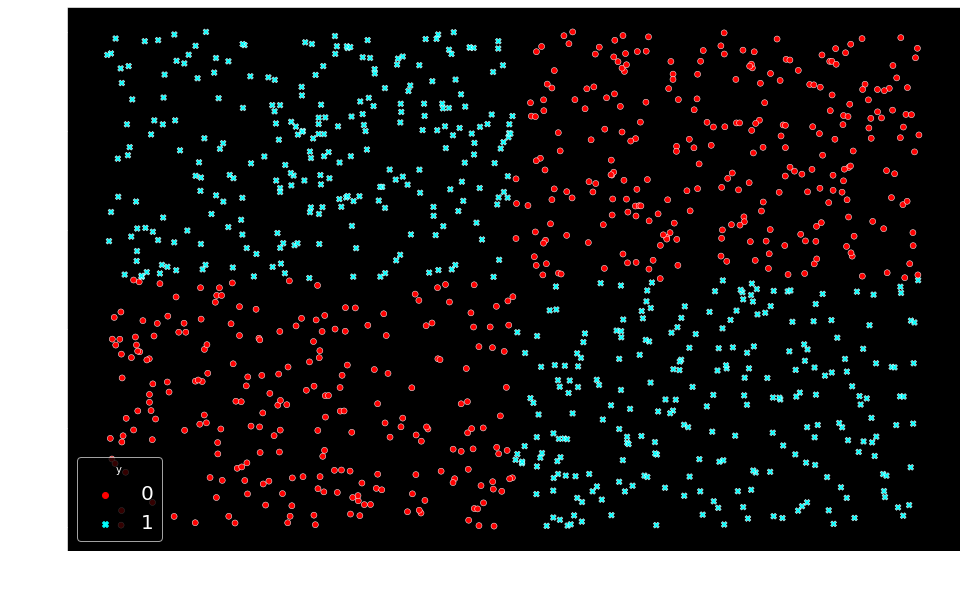

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("dark_background"); plt.rc('legend',fontsize=20)
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y",
                palette=["red", "cyan"]);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.show()

## Lets make the same NN first with PyTorch

In [3]:
import torch
import torch.nn as nn

class TwoNodeNetwork(nn.Module):
    def __init__(self):
        super(TwoNodeNetwork, self).__init__()
        self.h = nn.Linear(2,2)
        self.out = nn.Linear(2,1)
        
    def forward(self, x):
        x = torch.sigmoid(self.h(x))
        x = torch.sigmoid(self.out(x))
        return x

In [4]:
# Prepare the data
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, pd_df, mode = 'train'):
        self.mode = mode
        df = pd_df   
        
        if self.mode == 'train':
            self.input = df[["x1", "x2"]].values
            self.output = df["y"].values.reshape(len(df["y"]),1)
        else:
            self.input = df["y"]
            
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            inpt  = torch.Tensor(self.input[idx])
            outpt  = torch.Tensor(self.output[idx])
            return { 'inp': inpt,
                     'oup': outpt,
            }
        else:
            inpt = torch.Tensor(self.input[idx])
            return { 'inp': inpt
            }

In [5]:
from torch.optim import Adam
from torch.utils.data import DataLoader

criterion = nn.MSELoss()

model = TwoNodeNetwork()

optim = torch.optim.SGD(model.parameters(), lr = 0.01)

EPOCHS = 50000
BATCH_SIZE = 100

## Initialize the DataSet
data = MyDataset(df)

## Load the Dataset
data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, shuffle =False)

In [6]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
tb_writer = SummaryWriter(f'runs/2nodenet_{timestamp}')

In [7]:
for epoch in range(EPOCHS):
    epoch_loss = 0
    
    for i, batch in enumerate(data_train):
        x_train, y_train = batch['inp'], batch['oup']

        model.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        
        # Adjust model weights
        optim.step()

        # reporting progress
        epoch_loss+=loss
        
    if epoch % 100 == 0:
        tb_writer.add_scalar('Loss', epoch_loss, epoch)
        tb_writer.flush()
        
tb_writer.close()

In [8]:
data = torch.tensor(df[["x1", "x2"]].values, dtype=torch.float64)

In [9]:
model.eval()
with torch.no_grad():
    out = model.forward(data.float())

In [10]:
df["mynet_pred"] = out.numpy() >= 0.5

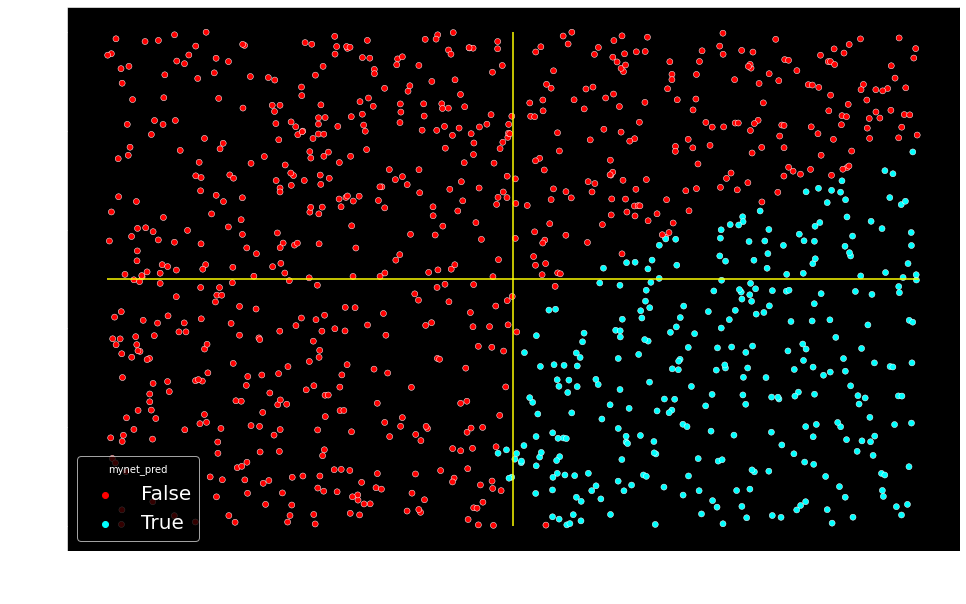

In [11]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="x1", y="x2", hue="mynet_pred",
               palette=['red', 'cyan']);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.hlines(xmin=0, xmax=100, y=[50], color='yellow')
plt.vlines(ymin=0, ymax=100, x=[50], color='yellow')
plt.show()

## Add one more layer:

In [12]:
class FourNodeNetwork(nn.Module):
    def __init__(self):
        super(FourNodeNetwork, self).__init__()
        self.h = nn.Linear(2,2)
        self.d = nn.Linear(2,2)
        self.out = nn.Linear(2,1)
        
    def forward(self, x):
        x = torch.sigmoid(self.h(x))
        x = torch.sigmoid(self.d(x))
        x = torch.sigmoid(self.out(x))
        return x

In [21]:
criterion = nn.MSELoss()

model2 = FourNodeNetwork()

optim = torch.optim.SGD(model2.parameters(), lr = 0.1)

EPOCHS = 50000
BATCH_SIZE = 100

## Initialize the DataSet
data = MyDataset(df)

## Load the Dataset
data_train = DataLoader(dataset = data, batch_size = BATCH_SIZE, shuffle =False)

In [22]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
tb_writer = SummaryWriter(f'runs/4nodenet_{timestamp}')
for epoch in range(EPOCHS):
    epoch_loss = 0
    
    for i, batch in enumerate(data_train):
        x_train, y_train = batch['inp'], batch['oup']

        model2.zero_grad()
        output = model2(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        
        # Adjust model weights
        optim.step()

        # reporting progress
        epoch_loss+=loss
        
    if epoch % 100 == 0:
        tb_writer.add_scalar('Loss', epoch_loss, epoch)
        tb_writer.flush()
        
tb_writer.close()

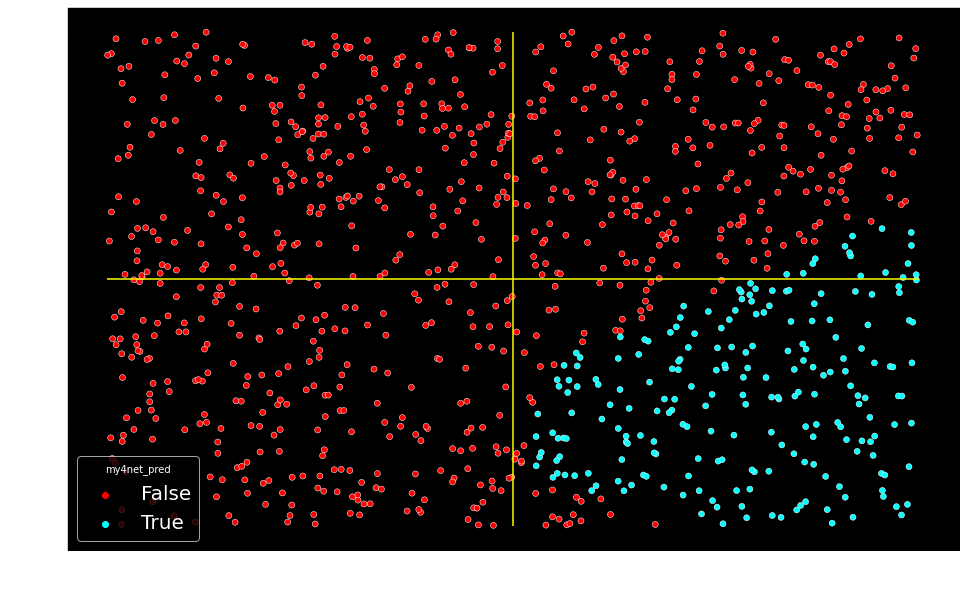

In [23]:
model.eval()
data = torch.tensor(df[["x1", "x2"]].values, dtype=torch.float64)
with torch.no_grad():
    out = model2.forward(data.float())

df["my4net_pred"] = out.numpy() >= 0.5
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df, x="x1", y="x2", hue="my4net_pred",
               palette=['red', 'cyan']);
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("x1", fontsize=22); plt.ylabel("x2", fontsize=22)
plt.hlines(xmin=0, xmax=100, y=[50], color='yellow')
plt.vlines(ymin=0, ymax=100, x=[50], color='yellow')
plt.show()